In [1]:
from models import UNETModule
import torch
from torch.utils.data import DataLoader


/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

### Water Bodies Dataset

In [3]:
from datasets.water_bodies_dataset import WaterBodiesDataset, SimpleWaterBodiesDataset
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.5, scale_limit=0.5, rotate_limit=30, p=0.5),
    A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.6, contrast_limit=0.6, p=0.5),
    ToTensorV2()
])

valid_transform = A.Compose([
    ToTensorV2(),
])


root = "../water-segmentation-vtx/dataset/"
train_dataset = SimpleWaterBodiesDataset(root, mode="train", transform=transform)
val_dataset = SimpleWaterBodiesDataset(root, mode="val", transform=valid_transform)

print("Train dataset length:", len(train_dataset))
print("Val dataset length:", len(val_dataset))

Train dataset length: 801
Val dataset length: 90


In [4]:
aosjdas = SimpleWaterBodiesDataset(root, mode="train", transform=transform)
aosjdas.__getitem__(0)["image"].shape, aosjdas.__getitem__(0)["mask"].shape

(torch.Size([3, 256, 256]), (1, 256, 256))

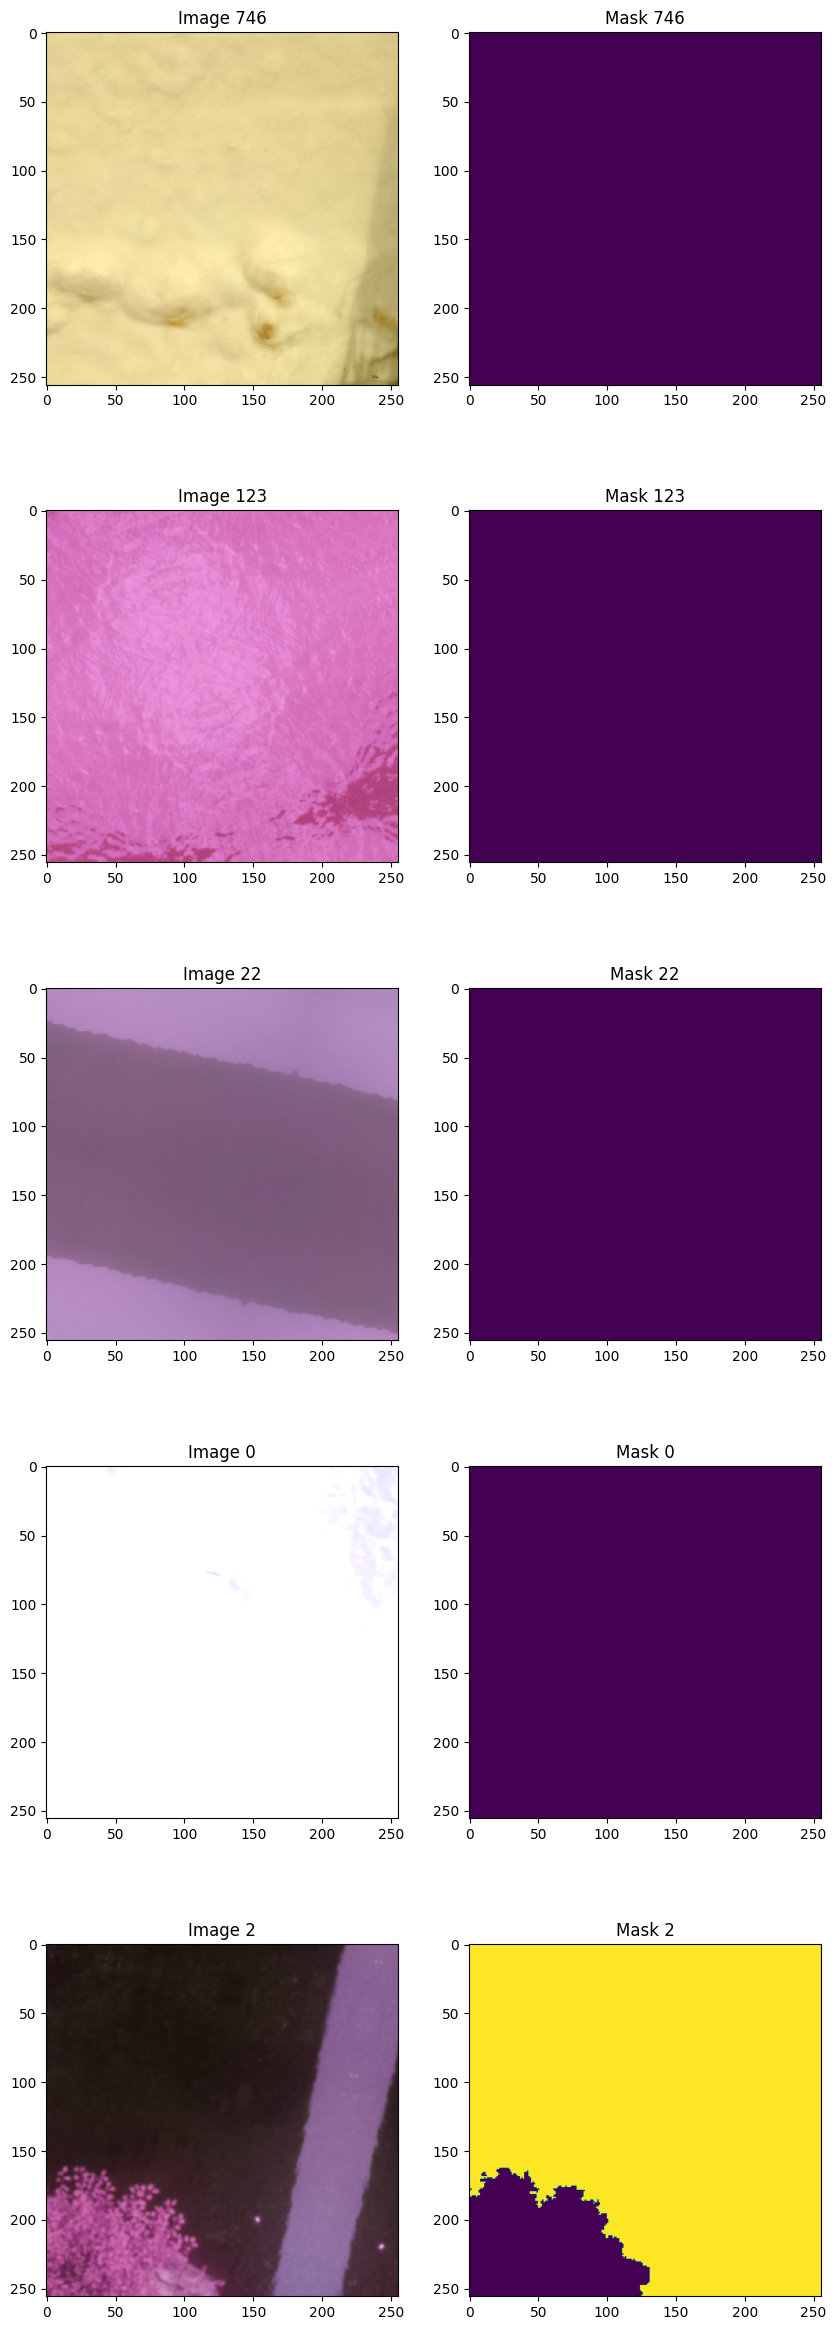

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Show some examples
random_images = False
examples = [746, 123, 22, 0, 2]
num_of_examples = 5
if random_images:
    examples = [np.random.randint(0, len_of_train_set) for _ in range(num_of_examples)]
len_of_train_set = train_dataset.__len__() 
fig, axes = plt.subplots(num_of_examples, 2, figsize=(10, 30))
for i, ex in enumerate(examples):
    example = train_dataset.__getitem__(ex)
    image_array = example["image"]
    mask_array = example["mask"]
    image = image_array.permute(1, 2, 0).int()
    mask = np.squeeze(mask_array, 0)
    axes[i][0].imshow(image)
    axes[i][0].set_title(f"Image {ex}")
    axes[i][1].imshow(mask)
    axes[i][1].set_title(f"Mask {ex}")
plt.show()
# HWC (480, 640, 3)
# CHW (3, 480, 640)

In [6]:
train_dataset.__getitem__(0)["image"].shape, train_dataset.__getitem__(0)["mask"].shape

(torch.Size([3, 256, 256]), (1, 256, 256))

#### Dataloader

In [7]:

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

In [8]:
train_dataset.__getitem__(746)["image"].shape, train_dataset.__getitem__(746)["mask"].shape 

#but got [3, 640, 480] at entry 0 and [3, 480, 640]

(torch.Size([3, 256, 256]), (1, 256, 256))

### Training

In [9]:
import torch
import pytorch_lightning as pl
import torchvision
import numpy as np
from lightning.pytorch.loggers import WandbLogger

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

unet_module = UNETModule(
    encoder="resnet152",
    encoder_weights="imagenet",
    loss_fn="jaccard", #"dice",
)
wandb_logger = WandbLogger(log_model="all")

unet_trainer = pl.Trainer(
    max_epochs=50,
    accelerator=accelerator,
    devices=1,
    logger=wandb_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
unet_trainer.fit(unet_module, train_dataloader, valid_dataloader)

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: rafaelmcelente. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name           | Type            | Params
---------------------------------------------------
0 | model          | Unet            | 67.2 M
1 | loss_fn        | JaccardLoss     | 0     
2 | validation_iou | SegmentationIOU | 0     
3 | training_iou   | SegmentationIOU | 0     
4 | test_iou       | SegmentationIOU | 0     
---------------------------------------------------
67.2 M    Trainable params
0         Non-trainable params
67.2 M    Total params
268.628   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from datasets.water_bodies_dataset import PredictionWaterBodiesDataset
predict_dataset = PredictionWaterBodiesDataset(root, transform=transform)
test_dataloader = DataLoader(predict_dataset, batch_size=8, shuffle=False, num_workers=n_cpu)
results  = unet_trainer.predict(unet_module, test_dataloader)

In [ ]:
first_batch = results[0]
logits, preds, filenames = first_batch
batch_size = logits.shape[0]
fig, axes = plt.subplots(batch_size, 3, figsize=(15, 30))

for i in range(batch_size):
    pred = preds[i, :, :, :]
    logit = logits[i, :,:,:]
    activations = torch.sigmoid(logit).float()
    
    
    filename, image_array = predict_dataset.__getitem__(i)
    image = np.transpose(image_array.astype(np.uint8), (1, 2, 0))
    prediction = Image.fromarray((np.squeeze(pred.cpu().numpy(), axis=0)*255).astype(np.uint8))
    activations = np.squeeze(activations.cpu().numpy(), axis=0)
    axes[i][0].imshow(image)
    axes[i][0].set_title(f"Image")
    axes[i][1].imshow(prediction)
    axes[i][1].set_title(f"Prediction")
    activations_image = axes[i][2].imshow(activations, cmap='hot', interpolation='nearest')
    fig.colorbar(activations_image, ax=axes[i][2])
    axes[i][2].set_title(f"Activations")

    
    

In [ ]:
import cv2

predictions_test = {}
for batch in results:
    logits, preds, filenames = batch
    batch_size = len(filenames)
    for i in range(batch_size):
        filename = filenames[i]
        pred = preds[i, :, :, :]
        predictions_test[filename] = pred
        
        pred = (pred.squeeze(0).numpy()*255).astype(np.uint8)
        cv2.imwrite(f'../water-segmentation-vtx/results/{filename}.png', pred)
    
predictions_test

In [ ]:
from create_submission_csv import rle_encode, create_csv
from datetime import datetime

current_time = datetime.now()
formatted_time = current_time.strftime('%Y-%m-%d_%H-%M-%S')
filename = f'./submission_{formatted_time}.csv'

create_csv('../water-segmentation-vtx/results/', filename)